# Import packages

In [1]:
from ast import literal_eval
import math
import numpy as np
import altair as alt
import pandas as pd
import shapely as shp
import geopandas as gpd
from datetime import timedelta, time
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider, CheckButtons

import itertools
from dijkstar import Graph, find_path

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

from helper_functions import open_processed_gtfs, open_delays, open_stations, plot_map_view

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Notebook settings

In [2]:
RESULTS_TOTAL_FILEPATH = r'Second model results\forward_total.csv'
RESULTS_WEEKDAYS_FILEPATH = r'Second model results\forward_weekday'
DELAYS_FILEPATH = r'Intermediates\\delays_assigned.csv'
LINKS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_links_corrected.geojson'
STATIONS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_stations_corrected.geojson'

# RESULTS_TOTAL_FILEPATH = r'Second model results\forward_weekday_0.csv'

DISTRIBUTION = stats.exponnorm
DISTRIBUTION_NAME = 'exponnorm'
PERCENTILE = 95

RESULTS_TOTAL_FILEPATH = f"{RESULTS_TOTAL_FILEPATH[:-4]}_{DISTRIBUTION_NAME}.csv"

# Load in data

In [3]:
gtfs_stations = open_stations(STATIONS_FILEPATH)
gtfs_stations.head(5)

,stop_id,stop_name,connections,geometry
0,E02,SHAW METRO STATION,"[[E03, E01], [E01, E03]]",POINT (1306094.353 454461.868)
1,D11,CHEVERLY METRO STATION,"[[D10, D12], [D12, D10]]",POINT (1336488.46 455202.936)
2,G02,CAPITOL HEIGHTS METRO STATION,"[[G01, G03], [G03, G01]]",POINT (1337007.377 445376.966)
3,E03,U STREET METRO STATION,"[[E04, E02], [E02, E04]]",POINT (1304034.044 455361.654)
4,D12,LANDOVER METRO STATION,"[[D11, D13], [D13, D11]]",POINT (1343622.123 461562.939)


In [4]:
links = gpd.read_file(LINKS_FILEPATH)
print(f"Amount of network connections: {len(links):_}")
links.head(3)

Amount of network connections: 189


,link_id,from_stop,to_stop,travel_time,geometry
0,A15_to_A14,A15,A14,240,"LINESTRING (-77.16476 39.11999, -77.14669 39.0..."
1,A14_to_A13,A14,A13,180,"LINESTRING (-77.14669 39.08545, -77.12079 39.0..."
2,A13_to_A12,A13,A12,180,"LINESTRING (-77.12079 39.06239, -77.11278 39.0..."


In [5]:
forward_result_total = pd.read_csv(RESULTS_TOTAL_FILEPATH)
forward_result_total['dist_params'] = [literal_eval(dist_params) for dist_params in forward_result_total['dist_params'].values]
if 'Unnamed: 0' in forward_result_total.columns:
    forward_result_total = forward_result_total.drop(columns=['Unnamed: 0'])
forward_result_total.head(5)

,timestep,from_stop,to_stop,dist_params
0,5.0,A01/C01,A02,"[1.6932084843842516, -46.61632500463405, 10.47..."
1,6.0,A01/C01,A02,"[1.4724190201183482, -43.87800761255711, 11.90..."
2,7.0,A01/C01,A02,"[1.4121326845647255, -38.864132458264876, 12.0..."
3,8.0,A01/C01,A02,"[1.2850950019381768, -33.17069368712228, 13.88..."
4,9.0,A01/C01,A02,"[1.9929803709128393, -38.393698881037736, 10.6..."


# Remove eroneuos connections

In [6]:
NON_EXISTENT_CONNECTIONS = [('C05', 'C07'), ('B01/F01', 'E02'), ('E01', 'F02'), ('A14', 'A12')] # Both directions

index_to_remove = []
for index, link in links.iterrows():
    if (link['from_stop'], link['to_stop']) in NON_EXISTENT_CONNECTIONS:
        index_to_remove.append(False)
    elif (link['to_stop'], link['from_stop']) in NON_EXISTENT_CONNECTIONS:
        index_to_remove.append(False)
    else:
        index_to_remove.append(True)

links = links[index_to_remove]

# Plot empty map

In [39]:
blue_route = ['J03', 'J02', 'C13', 'C12', 'C10', 'C09', 'C08', 'C07', 'C06', 'C05', 'C04', 'C03', 'C02', 'A01/C01', 'D01', 'D02', 'D03/F03', 'D04', 'D05', 'D06', 'D07', 'D08', 'G01', 'G02', 'G03', 'G04', 'G05']
orange_route = ['K08', 'K07', 'K06', 'K05', 'K04', 'K03', 'K02', 'K01', 'C05', 'C04', 'C03', 'C02', 'A01/C01', 'D01', 'D02', 'D03/F03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12', 'D13']
silver_route = ['N06', 'N04', 'N03', 'N02', 'N01', 'K05', 'K04', 'K03', 'K02', 'K01', 'C05', 'C04', 'C03', 'C02', 'A01/C01', 'D01', 'D02', 'D03/F03', 'D04', 'D05', 'D06', 'D07', 'D08', 'G01', 'G02', 'G03', 'G04', 'G05']
red_route = ['A15', 'A14', 'A13', 'A12', 'A11', 'A10', 'A09', 'A08', 'A07', 'A06', 'A05', 'A04', 'A03', 'A02', 'A01/C01', 'B01/F01', 'B02', 'B03', 'B35', 'B04', 'B05', 'B06/E06', 'B07', 'B08', 'B09', 'B10', 'B11', 'B35']
yellow_route = ['C15', 'C14', 'C13', 'C12', 'C10', 'C09', 'C08', 'C07', 'D03/F03', 'F02', 'B01/F01', 'E01']
green_route = ['F11', 'F10', 'F09', 'F08', 'F07', 'F06', 'F05', 'F04', 'D03/F03', 'F02', 'B01/F01', 'E01', 'E02', 'E03', 'E04', 'E05', 'B06/E06', 'E07', 'E08', 'E09', 'E10']
routes = [blue_route, orange_route, silver_route, red_route, yellow_route, green_route]
offsets_1 = [-0.0025, 0.0025, 0, 0, 0.001, -0.001]
offsets_2 = [-0.001, 0.001, 0, 0, 0.0005, -0.0005]
colors = ['blue', 'orange', 'silver', 'red', 'yellow', 'green']


def plot_map_view_blank(gtfs_stations: gpd.GeoDataFrame, links: gpd.GeoDataFrame,
                  non_pie_station_size: tuple[int, int]=[4, 5],
                  station_names_y_offset: tuple[float, float]=[0.002, 0.0005]
                  ) -> None:

    # Start figure, determine color scale
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot stations
    geodesic_stations = gtfs_stations.to_crs('EPSG:4326')
    for _, station in geodesic_stations.iterrows():
        ax1.plot(station['geometry'].x, station['geometry'].y, **{'color': 'grey', 'marker': 'o', 'markersize': 7}, zorder=1)
        ax2.plot(station['geometry'].x, station['geometry'].y, **{'color': 'grey', 'marker': 'o', 'markersize': 12}, zorder=1)

        # Plot station names
        x, y = station.geometry.x, station.geometry.y
        label = station['stop_id']
        ax1.text(x+0.0005, y+station_names_y_offset[0]+0.001, label, zorder=2, size=10, clip_on=True)
        ax2.text(x+0.0005, y+station_names_y_offset[1]+0.0005, label, zorder=2, size=10, clip_on=True)

    # Plot links
    geodesic_links = links.copy()
    geodesic_links = geodesic_links.to_crs('EPSG:4326')
    for _, link in geodesic_links.iterrows():
        for route, color, offset_1, offset_2 in zip(routes, colors, offsets_1, offsets_2):
            for from_stop, to_stop in zip(route[:-1], route[1:]):
                if (link['from_stop'] == from_stop) and (link['to_stop'] == to_stop):
                    link_geom = shp.offset_curve(link['geometry'], offset_1)
                    x, y = link_geom.xy
                    ax1.plot(x, y, color=color, linewidth=4, zorder=0)

                    link_geom = shp.offset_curve(link['geometry'], offset_2)
                    x, y = link_geom.xy
                    ax2.plot(x, y, color=color, linewidth=5, zorder=0)
                    break

    # Make red line appear on top
    for _, link in geodesic_links.iterrows():
        for from_stop, to_stop in zip(red_route[:-1], red_route[1:]):
            if (link['from_stop'] == from_stop) and (link['to_stop'] == to_stop):
                link_geom = shp.offset_curve(link['geometry'], 0)
                x, y = link_geom.xy
                ax1.plot(x, y, color='red', linewidth=4, zorder=0)

                link_geom = shp.offset_curve(link['geometry'], 0)
                x, y = link_geom.xy
                ax2.plot(x, y, color='red', linewidth=5, zorder=0)
                break

    # Plot make-up
    for ax_i in [ax1, ax2]:
        ax_i.set_aspect('equal', adjustable='box')
        # ax_i.axis('off')

        # ax_i.set_xticks([])
        # ax_i.set_yticks([])
        ax_i.set_ylabel('Latitude')
        ax_i.set_xlabel('Longitude')

    ax2.set_ylim(38.8385, 38.9340)
    ax2.set_xlim(-77.0915, -76.9619)

    plt.tight_layout()
    fig.savefig(r'Codebase figures\network_map.png', dpi=300)
    return fig


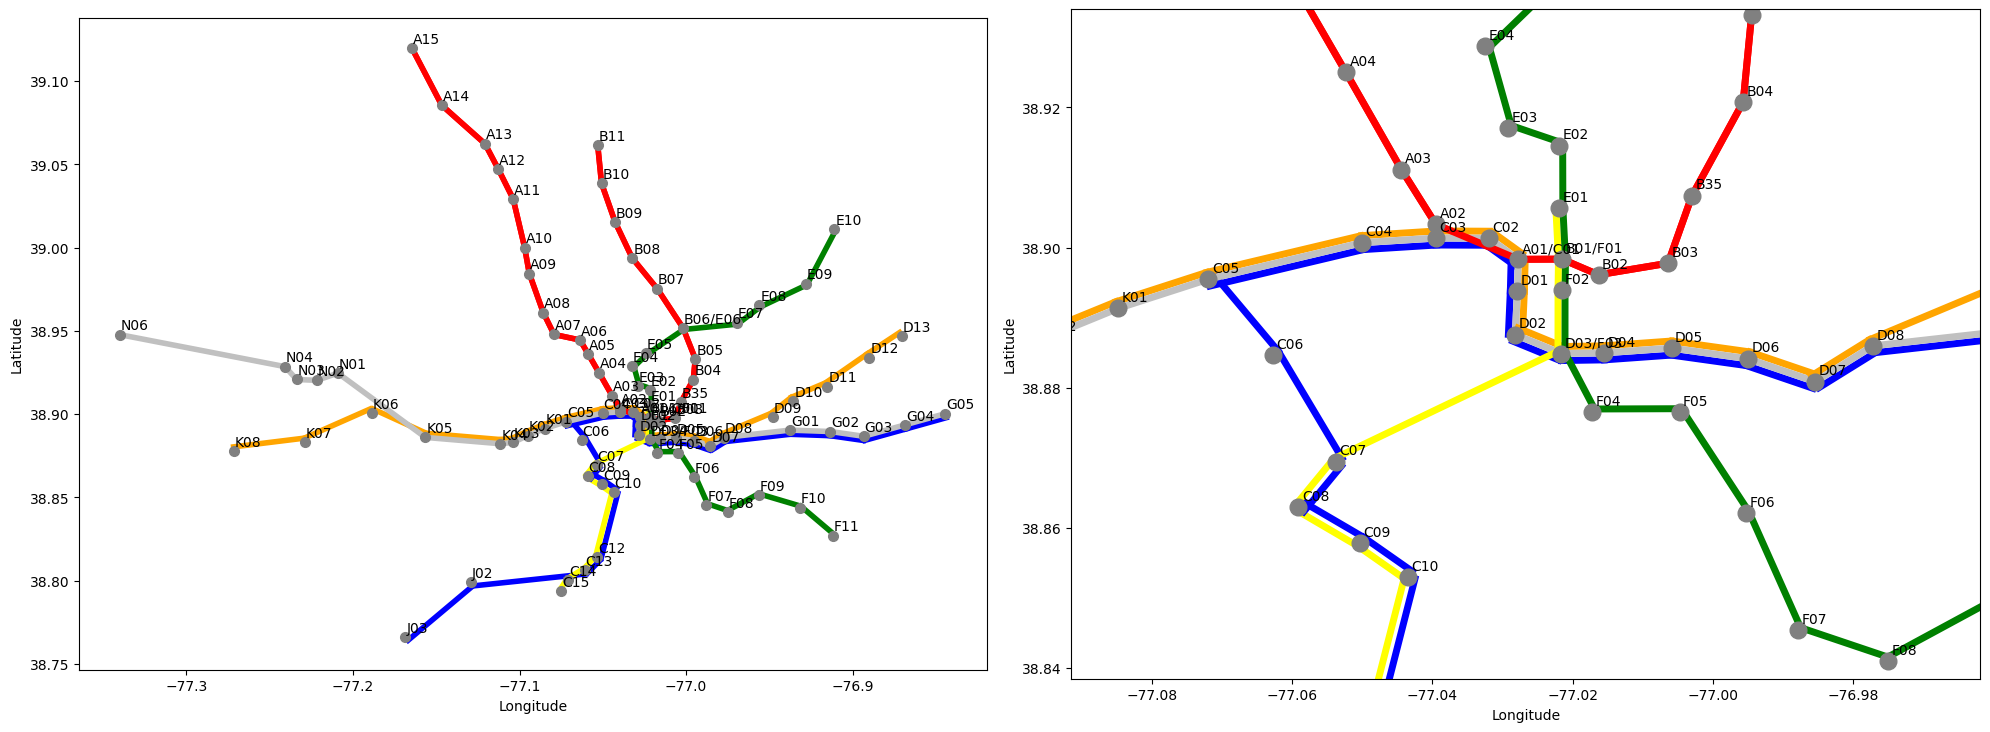

In [40]:
_ = plot_map_view_blank(gtfs_stations, links)

# Plot connection values

In [9]:
# For total result
means = []
highs = []
lows = []

high_percentile = ((PERCENTILE / 2) + 50) / 100
low_percentile = (50 - (PERCENTILE / 2)) / 100
print(high_percentile, low_percentile)

for index, result in forward_result_total.iterrows():
    # print(index)
    dist_params = result['dist_params']

    means.append(DISTRIBUTION.mean(*dist_params))
    highs.append(DISTRIBUTION.ppf(high_percentile, *dist_params))
    lows.append(DISTRIBUTION.ppf(low_percentile, *dist_params))

forward_result_total['mean'] = means
forward_result_total['high'] = highs
forward_result_total['low'] = lows

0.975 0.025


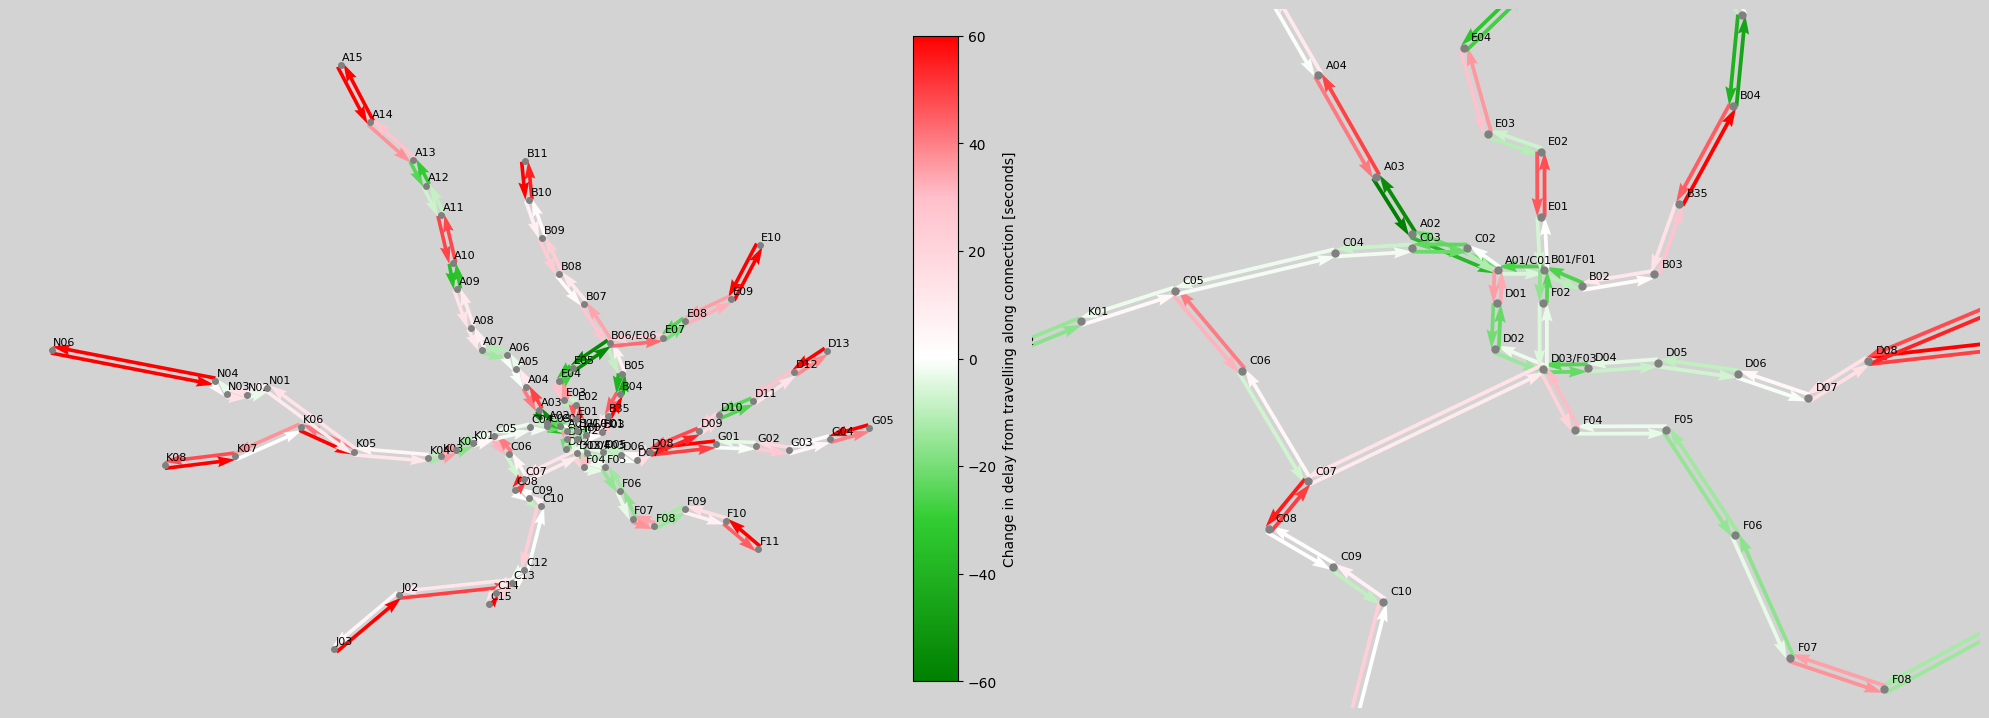

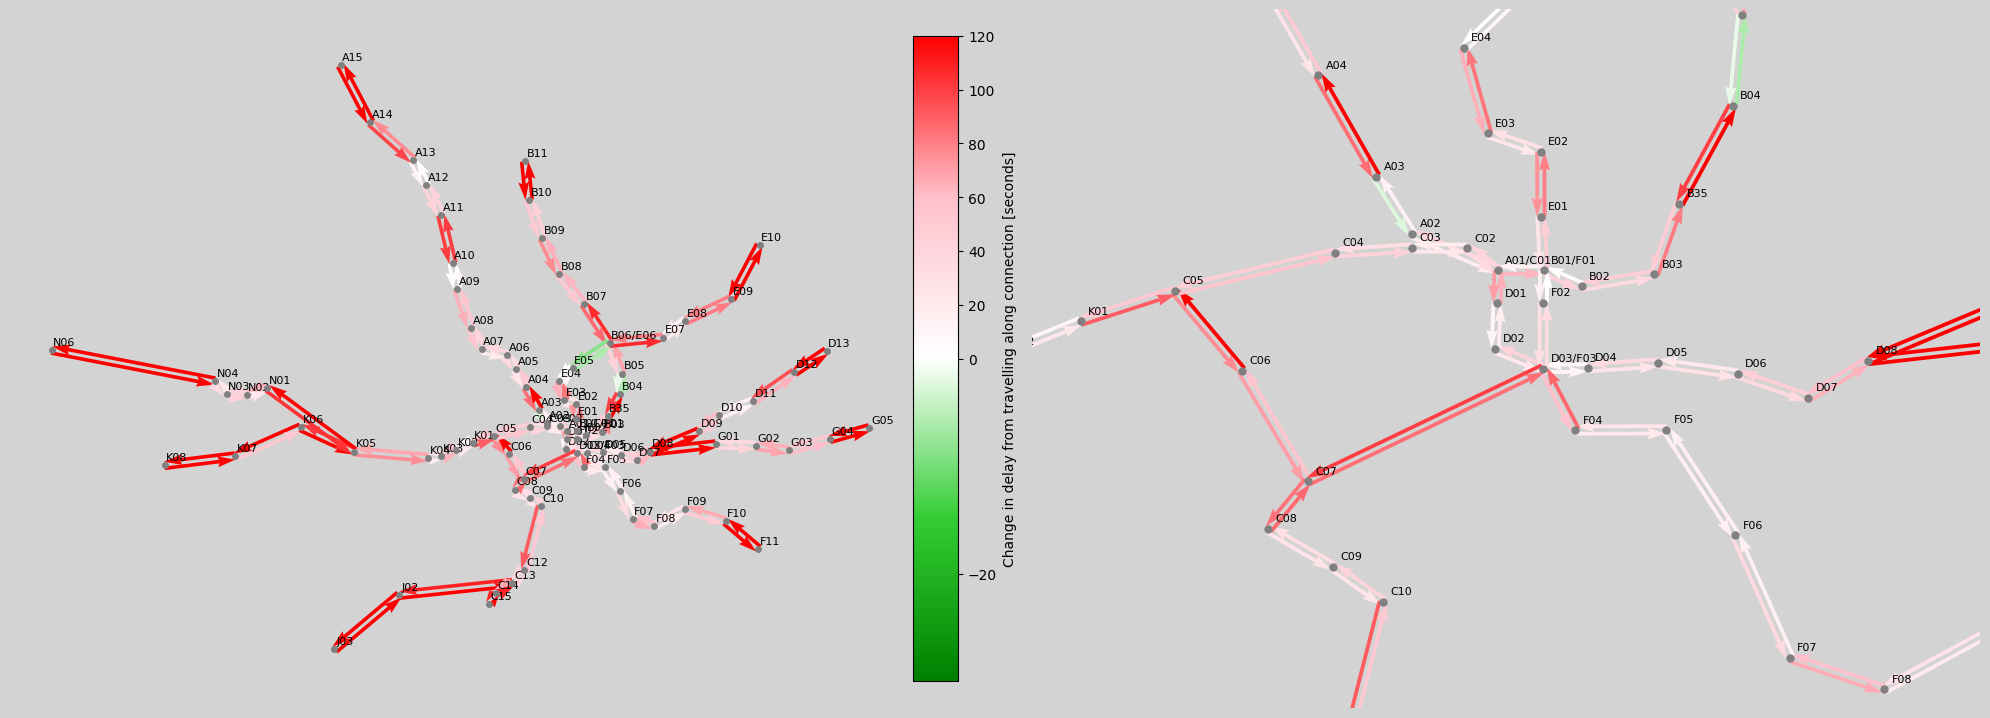

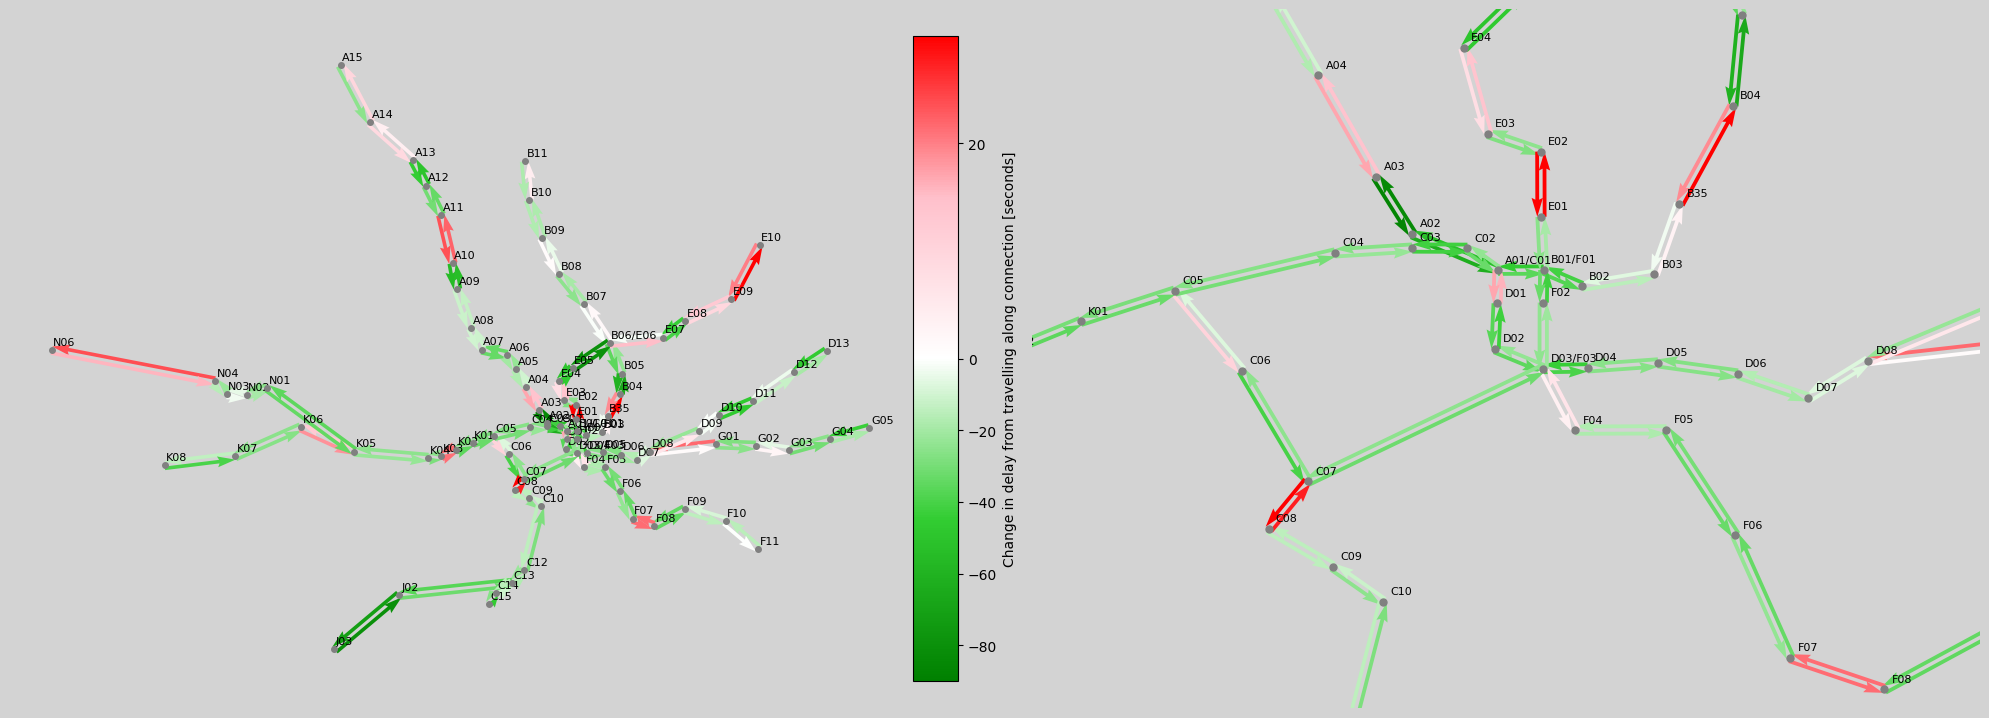

In [11]:
cmap_bounds = [[-60, 0, 60], [-30, 0, 120], [-90, 0, 30]]

for value_type, cmap_bound in zip(['mean', 'high', 'low'], cmap_bounds):
    connection_avgs = {connection: np.mean(connection_data[value_type]) for \
                        connection, connection_data in forward_result_total.groupby(['from_stop', 'to_stop'])}

    fig = plot_map_view(gtfs_stations, links, link_values=connection_avgs, cmap_bounds=cmap_bound)
    fig.savefig(rf'Codebase figures\second_model_{value_type}_map.png', dpi=300)